In [1]:
'''
We implement the code from the paper "Robustness and Reliability of Gender Bias Assessment in Word Embeddings: The Role of Base Pairs",
by Haiyang Zhang, Alison Sneyd and Mark Stevenson, AACL 2020
'''
# import packages
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import string 
import numpy as np
import json
import pandas as pd
import math
from collections import Counter
import re
import random
from sklearn.metrics import cohen_kappa_score
import scipy.stats


In [2]:
import torch
import pytorch_transformers
from pytorch_transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

'''
We test codes with the pre-trained BERT word embedding
'''

# defining a function that generates word embedding for bert

def get_bert_word_embedding(word, model_name='bert-base-uncased'):
  #load pretrained BERT model and tokenizer
  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertModel.from_pretrained(model_name)

  #tokenizing the word using the bert tokenizer
  tokens = tokenizer.tokenize(word)

  #converting the token(s) to each corresponding ID
  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  #create a tensor from the input ids
  input_tensor = torch.tensor([input_ids])

  #get the embeddings from BERT model
  with torch.no_grad():
    outputs = model(input_tensor)
  
  embedding = outputs[0].squeeze(0)[0]
  embedding = embedding.numpy()
  return embedding

In [3]:
# among BERT tokenizer entities we use 100 entities
entities = list(tokenizer.vocab.keys())[20000:20100]

In [26]:
#  Bolukbasi list professions
with open('data/professions1.json', 'r') as f:
        professions = json.load(f)
professions = [professions[i][0] for i in range(len(professions))] # list

# BSRI female
with open('data/bem_female_forms.txt', 'r') as f:
        bem_female_forms = json.load(f)  # dictionary word:variants
bem_female = [] # words in dict values to list
for v in bem_female_forms.values():
    for word in v:
        bem_female.append(word)

#  BSRI male        
with open('data/bem_male_forms.txt', 'r') as f:
        bem_male_forms = json.load(f)  # dictionary word:variants
bem_male = []
for v in bem_male_forms.values():
    for word in v:
        bem_male.append(word)
        
# Bolukbasi list of gender specific words       
with open('data/gender_specific_full.json') as f:
    gender_specific = json.load(f)

#  Bolukbasi long list of gender pairs
with open('data/equalize_pairs.json') as f:
    equalize_pairs = json.load(f)
    
# female animals
with open('data/frequent_female_animals.txt', 'r') as f: 
    f_animals = json.load(f) # list

# male animals
with open('data/frequent_male_animals.txt', 'r') as f:
    m_animals = json.load(f) # list
    
# test analogies file
with open("data/word-test.v1.txt", 'r') as infile:
    analogs = infile.readlines()
        
        
# make list defining gender pairs
# for measures & this list, + = female, - = male
def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), ('mary', 'john'),
              ('herself', 'himself'),('daughter', 'son'), ('mother', 'father')]


In [5]:
# DEFINE REDUCED VOCBULARIES
def safe_word(w):
    # ignore words with numbers, etc.
    # [a-zA-Z\.'_\- :;\(\)\]] for emoticons
    return (re.match(r"^[a-zA-Z_]*$", w) and len(w) < 20 and not re.match(r"^_*$", w))

def netural_word(w):
    # ignore words with numbers, etc.
    # [a-zA-Z\.'_\- :;\(\)\]] for emoticons
    return (re.match(r"^[a-z_]*$", w) and len(w) < 20 and not re.match(r"^_*$", w))

def limit_vocab(get_bert_word_embedding, exclude = None):
    vocab_limited = []
    vocab_neutral = []
    for entity in entities: 
        if safe_word(entity) == True:
             vocab_limited.append(entity)
        if netural_word(entity) == True:
            vocab_neutral.append(entity)
        
    if exclude:
        vocab_neutral = list(set(vocab_neutral) - set(exclude))
  
    print("size of limited vocabulary:", len(vocab_limited))
    
    wv_vocab = np.zeros((len(vocab_limited), 768))
    for i,w in enumerate(vocab_limited):
        wv_vocab[i,:] = get_bert_word_embedding(w)
    
    wv_neutral = np.zeros((len(vocab_neutral), 768))
    for i,w in enumerate(vocab_neutral):
        wv_neutral[i,:] = get_bert_word_embedding(w)
             
    w2i_neutral = {w: i for i, w in enumerate(vocab_neutral)}
    i2w_neutral = {i:w for w, i in w2i_neutral.items()}
    
    return vocab_limited, wv_vocab, vocab_neutral, wv_neutral, w2i_neutral, i2w_neutral


exclude_words = []
for pair in def_pairs + equalize_pairs:
    exclude_words.append(pair[0])
    exclude_words.append(pair[1])
exclude_words = list(set(exclude_words).union(set(gender_specific)))


vocab_limited, wv_vocab, vocab_neutral, wv_neutral, w2i_neutral, i2w_neutral = limit_vocab(get_bert_word_embedding, 
                                                                                           exclude_words)

size of limited vocabulary: 76


In [39]:
# DEFINE GENDER BIAS MEASURE FUNCTIONS

# Bolukbasi direct bias/ Caliskan word association with one base pair
def bdb(word, pair):
    word = get_bert_word_embedding(word)/np.linalg.norm(get_bert_word_embedding(word)) 
    pair0 = get_bert_word_embedding(pair[0])/np.linalg.norm(get_bert_word_embedding(pair[0]))
    pair1 = get_bert_word_embedding(pair[1])/np.linalg.norm(get_bert_word_embedding(pair[1]))
    db = np.dot(word, pair0-pair1)
    return db


# used to calculate ripa score
def b_vec(word_pair): 
    word1 = word_pair[0]
    word2 = word_pair[1]
    vec = get_bert_word_embedding(word1) - get_bert_word_embedding(word2)
    norm = np.linalg.norm(vec)
    
    return vec/norm


# RIPA bias measure with one base pair
def ripa1(word, bvec):
    word_vec = get_bert_word_embedding(word)
    
    return np.dot(word_vec, bvec)


# NBM get gender direction with specified neutral vocab and base pair
def compute_bias_by_projection(def_pair, vecs = wv_neutral, vocab = vocab_neutral):
    females = vecs.dot(get_bert_word_embedding(def_pair[0]))
    males = vecs.dot(get_bert_word_embedding(def_pair[1]))
    d = {}
    for w,m,f in zip(vocab, males, females):
        d[w] = f-m
    return d



# NBM get neiighbours
def topK(w, k=10):
    
    # extract the word vector for word w
    # idx = w2i_limited[w]
    # vec = wv_limited[idx, :]
    
    vec = get_bert_word_embedding(w)
    # compute similarity of w with all words in the restricted vocabulary
    sim = wv_neutral.dot(vec)
    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    best = sort_sim[:(k+1)]

    return [i2w_neutral[i] for i in best if i2w_neutral[i]!=w]



# NBM: get tuples of biases and counts of masculine/feminine NN for each word (for bias-by-neighbors)
def bias_by_neighbors(target_words,gender_bias, neighbours_num = 100):
    
    tuples = []
    neighbor_bias = {}
    for w in target_words:
        
        top = topK(w, k=neighbours_num+5)[:neighbours_num]
        
        m = 0
        f = 0    
        for t in top:
            if gender_bias[t] > 0:
                f+=1
            else:
                m+=1
        neighbor_bias[w] = (f-m)/(f+m)

        tuples.append((w, m, f, (f-m)/(f+m)))

    return neighbor_bias


# make dictionary of DB/WA scores for base pair list (keys) and vocab list
def make_bdb_scores_dict(word_pairs, word_list):
    bdb_scores = {}

    for pair in word_pairs:
        bdb_scores[pair] = []

        for word in word_list:
            score = bdb(word, pair)
            bdb_scores[pair].append(score)
            
    return bdb_scores

# make dictionary of RIPA scores for base pair list (keys) and vocab list
def make_ripa_scores_dict(word_pairs, word_list):
    ripa_scores = {}

    for pair in word_pairs:
        ripa_scores[pair] = []

        for word in word_list:
            bvec = b_vec(pair)
            score = ripa1(word, bvec)
            ripa_scores[pair].append(score)
            
    return ripa_scores

# make dictionary of NBM scores for base pair list (keys) and vocab list
def make_nbm_scores_dict(word_pairs, word_list):
    nbm_scores = {}
  
    for pair in word_pairs:
        direct_bias = compute_bias_by_projection(pair)
        nbm = bias_by_neighbors(word_list,direct_bias, neighbours_num = 100)
        nbm_scores[pair]=list(nbm.values())
    return nbm_scores

# turn bias scores to directions (male or female)
def make_binary(df):
    binary_df = df.copy()
    binary_df[binary_df<0] = 0
    binary_df[binary_df>0] = 1
    return binary_df

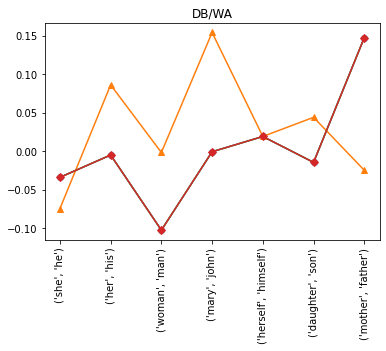

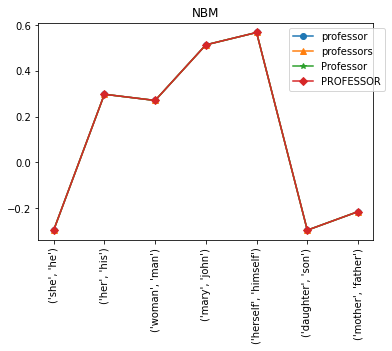

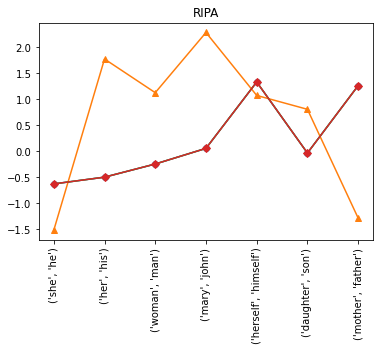

In [40]:
import matplotlib.pyplot as plt
# MAKE SCORE GRAPHS

# fn to plot scores of word list for a given measure and list of base pairs
def make_mag_plot_gen(gword_list, measure, pair_list, leg = False):

    length = len(pair_list)
    x = np.arange(length)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    graph_types = ["-o", "-^", "-*", "-D"]
    
    for i,word in enumerate(gword_list):
        graph_type = graph_types[i]

        if measure == "bdb":
            #oa_mean = bdb_oa_mean
            #oa_std = bdb_oa_std
            plt.title("DB/WA")
            #scores = [bdb(word, pair) for pair in pair_list]
            scores = make_bdb_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
        elif measure == "ripa1":
            plt.title("RIPA")
            #oa_mean = ripa_oa_mean
            #oa_std = ripa_oa_std
            scores = make_ripa_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
        elif measure == 'nbm':
            plt.title("NBM")
            #oa_mean = nbm_oa_mean
            #oa_std = nbm_oa_std
            scores = make_nbm_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
            
        else:
            print("Error- bad measure")
        plt.plot(x, scores, graph_type, label = word)


    #plt.plot(x, [oa_mean for i in range(length)], "g--", label = "mean")
    #plt.plot(x, [oa_mean-oa_std for i in range(length)], "-.",color = "orange", label = "1 standard deviation")
    #plt.plot(x, [oa_mean+oa_std for i in range(length)],  "-.",color = "orange", label =  "")
    #plt.plot(x, [oa_mean-2*oa_std for i in range(length)],  "r:", label = "2 standard deviations")
    #plt.plot(x, [oa_mean+2*oa_std for i in range(length)],  "r:", label = "")
    plt.xticks(x, pair_list, rotation='vertical')

    if leg == True:
        plt.legend()
        ax.legend(bbox_to_anchor=(1.05, 1.0))
    plt.show()


# make plots showing bias score variation
make_mag_plot_gen(['professor', 'professors', 'Professor', 'PROFESSOR'], "bdb", def_pairs)
make_mag_plot_gen(['professor', 'professors', 'Professor', 'PROFESSOR'], "nbm", def_pairs, leg = True)
make_mag_plot_gen(['professor', 'professors', 'Professor', 'PROFESSOR'], "ripa1", def_pairs)

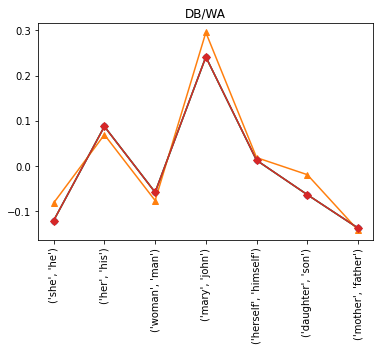

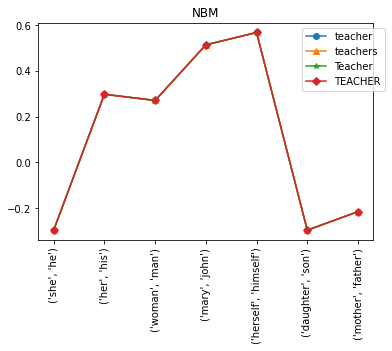

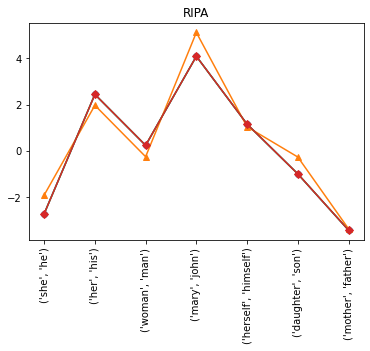

In [41]:
import matplotlib.pyplot as plt
# MAKE SCORE GRAPHS

# fn to plot scores of word list for a given measure and list of base pairs
def make_mag_plot_gen(gword_list, measure, pair_list, leg = False):

    length = len(pair_list)
    x = np.arange(length)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    graph_types = ["-o", "-^", "-*", "-D"]
    
    for i,word in enumerate(gword_list):
        graph_type = graph_types[i]

        if measure == "bdb":
            #oa_mean = bdb_oa_mean
            #oa_std = bdb_oa_std
            plt.title("DB/WA")
            #scores = [bdb(word, pair) for pair in pair_list]
            scores = make_bdb_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
        elif measure == "ripa1":
            plt.title("RIPA")
            #oa_mean = ripa_oa_mean
            #oa_std = ripa_oa_std
            scores = make_ripa_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
        elif measure == 'nbm':
            plt.title("NBM")
            #oa_mean = nbm_oa_mean
            #oa_std = nbm_oa_std
            scores = make_nbm_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
            
        else:
            print("Error- bad measure")
        plt.plot(x, scores, graph_type, label = word)


    #plt.plot(x, [oa_mean for i in range(length)], "g--", label = "mean")
    #plt.plot(x, [oa_mean-oa_std for i in range(length)], "-.",color = "orange", label = "1 standard deviation")
    #plt.plot(x, [oa_mean+oa_std for i in range(length)],  "-.",color = "orange", label =  "")
    #plt.plot(x, [oa_mean-2*oa_std for i in range(length)],  "r:", label = "2 standard deviations")
    #plt.plot(x, [oa_mean+2*oa_std for i in range(length)],  "r:", label = "")
    plt.xticks(x, pair_list, rotation='vertical')

    if leg == True:
        plt.legend()
        ax.legend(bbox_to_anchor=(1.05, 1.0))
    plt.show()


# make plots showing bias score variation
make_mag_plot_gen(['teacher', 'teachers', 'Teacher', 'TEACHER'], "bdb", def_pairs)
make_mag_plot_gen(['teacher', 'teachers', 'Teacher', 'TEACHER'], "nbm", def_pairs, leg = True)
make_mag_plot_gen(['teacher', 'teachers', 'Teacher', 'TEACHER'], "ripa1", def_pairs)

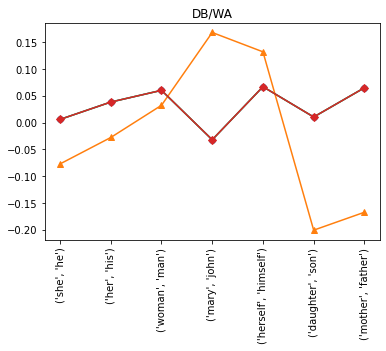

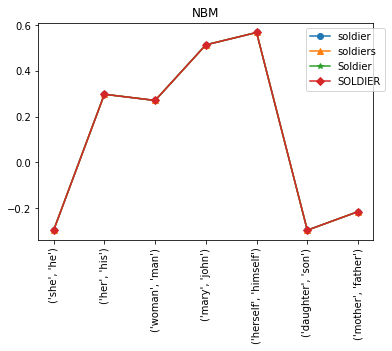

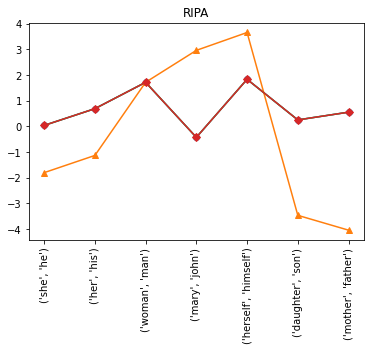

In [42]:
import matplotlib.pyplot as plt
# MAKE SCORE GRAPHS

# fn to plot scores of word list for a given measure and list of base pairs
def make_mag_plot_gen(gword_list, measure, pair_list, leg = False):

    length = len(pair_list)
    x = np.arange(length)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    graph_types = ["-o", "-^", "-*", "-D"]
    
    for i,word in enumerate(gword_list):
        graph_type = graph_types[i]

        if measure == "bdb":
            #oa_mean = bdb_oa_mean
            #oa_std = bdb_oa_std
            plt.title("DB/WA")
            #scores = [bdb(word, pair) for pair in pair_list]
            scores = make_bdb_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
        elif measure == "ripa1":
            plt.title("RIPA")
            #oa_mean = ripa_oa_mean
            #oa_std = ripa_oa_std
            scores = make_ripa_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
        elif measure == 'nbm':
            plt.title("NBM")
            #oa_mean = nbm_oa_mean
            #oa_std = nbm_oa_std
            scores = make_nbm_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
            
        else:
            print("Error- bad measure")
        plt.plot(x, scores, graph_type, label = word)


    #plt.plot(x, [oa_mean for i in range(length)], "g--", label = "mean")
    #plt.plot(x, [oa_mean-oa_std for i in range(length)], "-.",color = "orange", label = "1 standard deviation")
    #plt.plot(x, [oa_mean+oa_std for i in range(length)],  "-.",color = "orange", label =  "")
    #plt.plot(x, [oa_mean-2*oa_std for i in range(length)],  "r:", label = "2 standard deviations")
    #plt.plot(x, [oa_mean+2*oa_std for i in range(length)],  "r:", label = "")
    plt.xticks(x, pair_list, rotation='vertical')

    if leg == True:
        plt.legend()
        ax.legend(bbox_to_anchor=(1.05, 1.0))
    plt.show()


# make plots showing bias score variation
make_mag_plot_gen(['soldier', 'soldiers', 'Soldier', 'SOLDIER'], "bdb", def_pairs)
make_mag_plot_gen(['soldier', 'soldiers', 'Soldier', 'SOLDIER'], "nbm", def_pairs, leg = True)
make_mag_plot_gen(['soldier', 'soldiers', 'Soldier', 'SOLDIER'], "ripa1", def_pairs)